# DistilBert

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics,
    get_error_analysis,
    print_error_df
)

### Setup

In [3]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
# DATA_PATH = "../data/data_small.csv"
DATA_PATH = "../data/data_multiclass_without_none.csv" # uncomment this when checking that everything is just running properly. 
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
OUTPUT_DIR = "../models/distilbert_binary/trainer_output"
SAVE_PATH = "../models/distilbert_binary/pytorch_model"

### Get data

In [7]:
# use "binary" for binary classification and "multiclass" for multiclass classification
train_dataset, test_dataset, encoded_train_dataset, encoded_test_dataset, le = get_encode_tokenize_data("multiclass", DATA_PATH, MODEL_PATH)

INFO:basic_functions:Loading data...
INFO:basic_functions:Train test split, test-size 0.3
INFO:root:Create encoded dataframes
INFO:root:Encode the label column
INFO:root:Tokenize
INFO:basic_functions:create tokenizer & load model
INFO:basic_functions:create tokenizer & load model
INFO:root:Create TextDatasets (train & test)


In [8]:
y_train = encoded_train_dataset['logical_fallacies']

### Model Initialization

In [9]:
learning_rate= 3e-5
weight_decay= 0.01
num_train_epochs= 4
evaluation_strategy= 'epoch'
class_weight=True
dropout= 0.3


params = {
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "num_train_epochs": num_train_epochs,
      "evaluation_strategy": evaluation_strategy,
      "class_weight":class_weight,
      "dropout": dropout,
      "dataset": DATA_PATH
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "Distilbert Binary")
mlflow.log_params(params)

Active run_id: f2e70834dbd445a7a6437d4fe87b9669


In [10]:
num_classes = len(np.unique(y_train))
num_classes

5

In [11]:
# Load config and set dropout
config = AutoConfig.from_pretrained(MODEL_TRAINING_PATH)
config.num_labels = num_classes # Set number of labels for classification
config.dropout = dropout # Set dropout, default is 0.1

# Load model with updated config
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    config=config  # Pass modified config
)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=class_weight, 
    epochs=num_train_epochs, 
    learning_rate=learning_rate, 
    weight_decay = weight_decay, 
    train_batch_size=4, 
    eval_batch_size=8 )

INFO:root:defining training arguments
INFO:root:get weighted loss trainer


### Execute Training

In [13]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [14]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [15]:
logger.info('training is running')
trainer.train()

INFO:root:training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,0.743400,0.673494,0.752000
2,0.474200,0.653469,0.808000
3,0.453000,0.871105,0.781333
4,0.224900,0.907220,0.797333


TrainOutput(global_step=1752, training_loss=0.5984394501333368, metrics={'train_runtime': 642.6615, 'train_samples_per_second': 10.892, 'train_steps_per_second': 2.726, 'total_flos': 927321400320000.0, 'train_loss': 0.5984394501333368, 'epoch': 4.0})

### Evaluation


In [16]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

INFO:root:predict on test_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.79      0.74      0.76       151
appeal_to_authority       0.78      0.85      0.82       143
  appeal_to_emotion       0.72      0.75      0.74       155
      false_dilemma       0.89      0.81      0.85       151
     slippery_slope       0.86      0.89      0.88       150

           accuracy                           0.81       750
          macro avg       0.81      0.81      0.81       750
       weighted avg       0.81      0.81      0.81       750



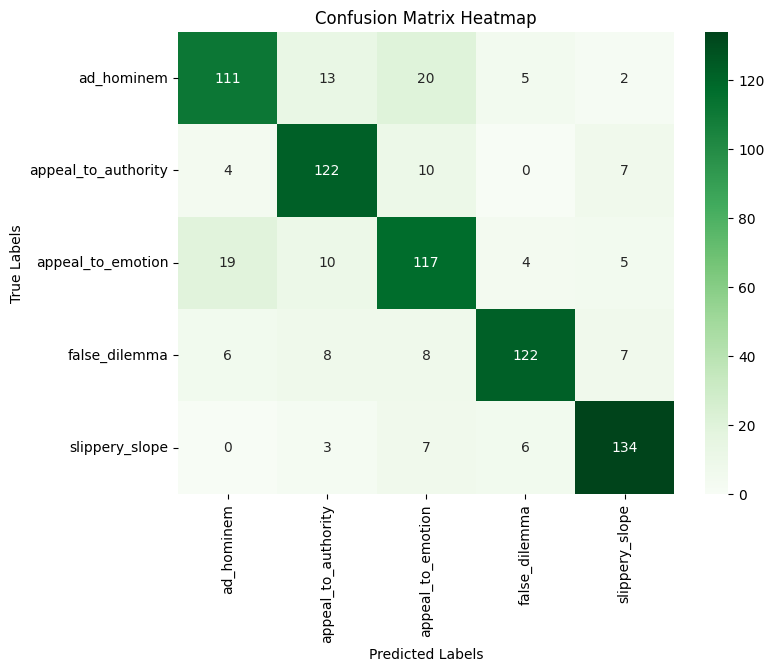

INFO:basic_functions:brier score


Multiclass Brier score: 0.3126581546290803


In [17]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


INFO:root:predict on train_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.93      0.89      0.91       352
appeal_to_authority       0.87      0.93      0.90       333
  appeal_to_emotion       0.84      0.91      0.87       360
      false_dilemma       0.95      0.85      0.90       354
     slippery_slope       0.94      0.95      0.94       351

           accuracy                           0.90      1750
          macro avg       0.91      0.90      0.90      1750
       weighted avg       0.91      0.90      0.90      1750



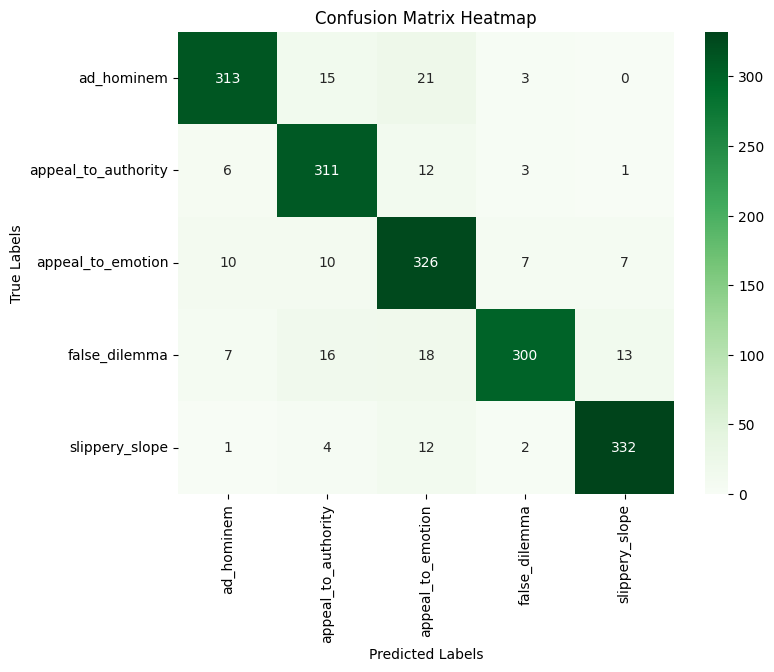

INFO:basic_functions:brier score


Multiclass Brier score: 0.152074314376674


In [18]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [19]:
mlflow.end_run()

🏃 View run Distilbert Binary at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/f2e70834dbd445a7a6437d4fe87b9669
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451


### Save model

In [20]:
# #save with pytorch
# mlflow.pytorch.save_model(model, path=SAVE_PATH)

### Error Analysis

In [21]:
df_error_test = get_error_analysis(test_output, encoded_test_dataset)

In [22]:
# get text, which is predicted false
print_error_df(df_error_test)

Example 0:
Text: If we don t resolve that issue all others become irrelevant
True Label: 4, Predicted Label: 3
Example 1:
Text: But it s not only women and it s not only this video that raises questions about his fitness to be our president because he has also targeted immigrants African Americans Latinos people with disabilities POWs Muslims and so many others So
True Label: 0, Predicted Label: 2
Example 2:
Text: Now that I think is one of the most serious sort of reversals or mixed messages that you could possibly send
True Label: 2, Predicted Label: 0
Example 3:
Text: The similarity between the ideas engraved on the Georgia Guidestones those espoused in the Earth Charter reflect the common origins of both Earth Charter serves as the basis for the UN document known as Agenda 21 Sustainable Development Depopulation
True Label: 2, Predicted Label: 1
Example 4:
Text: All of my friends are coming to my birthday party If Micah doesn t she might as well tell me that she doesn t like me
Tru

In [23]:
# get dataset, with most false predicted values
df_counts = df_error_test[['dataset', 'true_label', 'pred_label']].groupby(['dataset', 'true_label']).value_counts().reset_index()
df_counts.sort_values('count', ascending=False)

,dataset,true_label,pred_label,count
39,9,0,2,9
44,9,2,0,8
41,9,1,2,7
48,9,4,2,6
45,9,2,1,6
16,3,1,4,6
5,1,3,2,5
18,3,3,1,5
17,3,3,4,5
36,8,2,0,4
